In [ ]:
#!/usr/bin/env python
# coding: utf-8
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt


## 영어 "hello"를 스페인어 "hola"로 번역하기 mission
vocab_size = 256  # 총 아스키 코드 개수
x_ = list(map(ord, "hello"))  # 아스키 코드 리스트로 변환
y_ = list(map(ord, "hola"))   # 아스키 코드 리스트로 변환
print("hello -> ", x_)
print("hola  -> ", y_)

x = torch.LongTensor(x_)
y = torch.LongTensor(y_)

hello ->  [104, 101, 108, 108, 111]
hola  ->  [104, 111, 108, 97]


In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(Seq2Seq, self).__init__()
        self.dropout_p=0.2
        self.n_layers = 1   # 은닉 벡터들의 층
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)

        ## RNN으로 구성된 기본 제공 모델 -> LSTM, GRU로 자유롭게 수정
        self.encoder = nn.GRU(hidden_size, hidden_size, dropout=self.dropout_p)
        self.decoder = nn.GRU(hidden_size, hidden_size, dropout=self.dropout_p)
        self.project = nn.Linear(hidden_size, vocab_size)

    def forward(self, inputs, targets):
        # 인코더에 들어갈 입력
        initial_state = self._init_state()
        ## embedding = self.embedding(inputs).unsqueeze(1)
        embedding = self.dropout(self.embedding(inputs)).unsqueeze(1)
        ## embedding = [seq_len, batch_size, embedding_size]
        
        # 인코더 (Encoder)
        encoder_output, encoder_state = self.encoder(embedding, initial_state)
        ## encoder_output = [seq_len, batch_size, hidden_size]
        ## encoder_state  = [n_layers, seq_len, hidden_size]

        # 디코더에 들어갈 입력
        decoder_state = encoder_state
        decoder_input = torch.LongTensor([0])
        
        # 디코더 (Decoder)
        outputs = []
        for i in range(targets.size()[0]):
            decoder_input = self.embedding(decoder_input).unsqueeze(1)
            ## decoder_input = self.dropout(self.embedding(decoder_input)).unsqueeze(1)

            decoder_output, decoder_state = self.decoder(decoder_input, decoder_state)

            projection = self.project(decoder_output)

            outputs.append(projection)
            decoder_input = torch.LongTensor([targets[i]])

        outputs = torch.stack(outputs).squeeze()
        return outputs
    
    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_size).zero_()

In [ ]:
seq2seq = Seq2Seq(vocab_size, 128)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=0.001)
EPOCH = 1000

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))



 반복:0 오차: 5.529699325561523
['\x06', 'ø', 'à', 'ß']

 반복:100 오차: 0.011489687487483025
['h', 'o', 'l', 'a']

 반복:200 오차: 0.004874242469668388
['h', 'o', 'l', 'a']

 반복:300 오차: 0.0027814405038952827
['h', 'o', 'l', 'a']

 반복:400 오차: 0.0018354604253545403
['h', 'o', 'l', 'a']

 반복:500 오차: 0.0013134102337062359
['h', 'o', 'l', 'a']

 반복:600 오차: 0.0009953140979632735
['h', 'o', 'l', 'a']

 반복:700 오차: 0.0007827761583030224
['h', 'o', 'l', 'a']

 반복:800 오차: 0.0006336031947284937
['h', 'o', 'l', 'a']

 반복:900 오차: 0.0005249478854238987
['h', 'o', 'l', 'a']


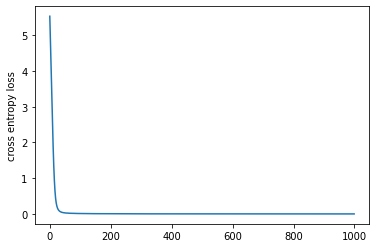

In [ ]:
log = []
for i in range(EPOCH): # Epoch은 고정
    prediction = seq2seq(x, y)
    loss = criterion(prediction, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_val = loss.data
    log.append(loss_val)
    if i % 100 == 0:
        print("\n 반복:%d 오차: %s" % (i, loss_val.item()))
        _, top1 = prediction.data.topk(1, 1)
        print([chr(c) for c in top1.squeeze().numpy().tolist()])

# matplotlib : 그래프를 그려주는 파이썬 라이브러리
plt.plot(log)
plt.ylabel('cross entropy loss')
plt.show()